In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply
import ipywidgets as iw
from oneibl import one
import brainbox.plot as bbp
from fitplot_funs import err_wght_sync
from export_funs import trialinfo_to_df, session_trialwise
from brainbox.core import TimeSeries
from brainbox.processing import sync

%matplotlib inline

fit_types = {'Stimulus on L': 'stim_L',
             'Stimulus on R': 'stim_R',
             'Feedback correct': 'fdbck_corr',
             'Feedback incorrect': 'fdbck_incorr',
             'Prior estimate gain': 'prior',
             'Wheel Velocity': 'velocity'}

# Iterate though directories and find which mice/sessions we have fits for
mice = [x for x in os.listdir('./fits/') if os.path.isdir('./fits/' + x)]
fitsess = {mouse: [y[:-2] for y in os.listdir(f'./fits/{mouse}/') if y.split('.')[-1] == 'p'] for mouse in mice}

mousewidget = iw.Dropdown(options=mice)
sesswidget = iw.Dropdown()
cellwidget = iw.Dropdown()
fitwidget = iw.Dropdown()

def updatesess(*args):
    sesswidget.options = fitsess[mousewidget.value]
sesswidget.observe(updatesess)

mouse = 'ZM_2240'
sess = '2020-01-22_session_2020-05-18_probe0_fit.p'
probe_idx=0


fits = np.load(f'./fits/{mouse}/{sess}', allow_pickle=True)
wts_per_kern = fits['wts_per_kern']
kern_length = fits['kern_length']
binw = fits['glm_binsize']
uuid = fits['session_uuid']
p_est = fits['prior_est']
trdf = trialinfo_to_df(uuid, maxlen=2.)
one = one.ONE()
spikes = one.load(uuid, ['spikes.times'])[probe_idx]
clu = one.load(uuid, ['spikes.clusters'])[probe_idx]


trials, clu_ids = session_trialwise(uuid, t_before=0.3, probe_idx=probe_idx, wheel=True)
kern_length = fits['kern_length']
glm_binsize = fits['glm_binsize']
for tr in trials:
    tr['wheel_t'][0] = 0.  # Manual previous-value interpolation
    whlseries = TimeSeries(tr['wheel_t'], tr['wheel_pos'], columns=['whlpos'])
    whlsync = sync(glm_binsize, timeseries=whlseries, interp='previous')
    trialstartind = np.searchsorted(whlsync.times, 0)
    trialendind = np.ceil((tr['feedback_times'] + kern_length) / glm_binsize).astype(int)
    trpos = whlsync.values[trialstartind:trialendind + trialstartind]
    whlvel = trpos[1:] - trpos[:-1]
    whlvel = np.insert(whlvel, 0, 0)
    if np.abs(trialendind - len(whlvel)) > 0:
        raise IndexError('Mismatch between expected length of wheel data and actual.')
    tr['velocity'] = whlvel


Connected to https://alyx.internationalbrainlab.org as berk.gercek
Connected to https://alyx.internationalbrainlab.org as berk.gercek


In [2]:
from export_funs import session_trialwise
from brainbox.core import TimeSeries
from brainbox.processing import sync
percentile = 98# We should only show cells whose prior gain / gain estimate variance is above this percentile
fullfits = fits['fits']
fitdf = fullfits[np.isfinite(fullfits.varprior) & np.isfinite(fullfits.varvel)]
prior_threshold = np.percentile(np.abs(fitdf.prior / fitdf.varprior), percentile)
vel_threshold = np.percentile(np.abs(fitdf.velocity), percentile)
subsetdf = fitdf[(np.abs(fitdf.prior / fitdf.varprior) > prior_threshold) | (np.abs(fitdf.velocity) > vel_threshold)]
if 'bias' not in trdf.columns:
    trdf = trdf.join(p_est)
trdf = trdf[np.isfinite(trdf.bias)]

In [3]:
# trdf.insert(9, 'meanvel', np.nan)
for trnum in trdf.index:
    currtr = [tr for tr in trials if tr['trialnum'] == trnum][0]
    fdbkind = int((currtr['feedback_times'] + 0.4) // glm_binsize)
    numinds = int(0.6 // glm_binsize)
    meanvel = np.mean(currtr['velocity'][fdbkind - numinds:fdbkind])
    trdf.loc[trnum, 'meanvel'] = meanvel

11962.963423954905

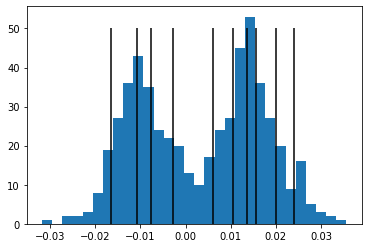

In [4]:
plt.hist(trdf.meanvel, 30)
percvals = np.percentile(trdf.meanvel, [5, 20, 30, 40, 50, 60, 70, 80, 90, 95])
plt.vlines(percvals, 0, 50)
vel_threshold
prior_threshold

In [5]:
from matplotlib.colors import ListedColormap

SMALLER_SIZE = 16
SMALL_SIZE = 24
MEDIUM_SIZE = 28
BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALLER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

@iw.interact
def plot_kern(cell=subsetdf.index.to_list(), kern=fit_types.keys()):
    currfit = fitdf.loc[cell]
    timescale = np.arange(0, kern_length, binw)
    currkern = fit_types[kern]
    if currkern in ('stim_L', 'stim_R'):
        weight = currfit[currkern]
        err = np.sqrt(currfit['var' + currkern])
        side = 'Left' if currkern == 'stim_L' else 'Right' 
        label = f'{side} stimulus onset'
        title = f'Kernel fit to {side} stimulus onset'
        event_t = trdf[np.isfinite(trdf['contrast' + side])].stimOn_times
    elif currkern in ('fdbck_corr', 'fdbck_incorr'):
        weight = currfit[currkern]
        err = np.sqrt(currfit['var' + currkern])
        ftype = 'Correct' if currkern == 'fdbck_corr' else 'Incorrect'
        fcat = 1 if currkern == 'fdbck_corr' else -1
        label = f'{ftype} feedback'
        title = f'Kernel fit to {ftype} feedback'
        event_t = trdf[trdf.feedbackType == fcat].stimOn_times
    elif fit_types[kern] == 'decision':
        fig, axes = plt.subplots(2, 1, figsize=(15, 9))
        timescale = np.arange(0, kern_length * 0.5, binw)
        weight1 = currfit['decision_L']
        weight2 = currfit['decision_R']
        err1 = np.zeros_like(weight1)
        err2 = np.zeros_like(weight2)
        label1 = 'Left Decision'
        label2 = 'Right Decision'
        title = 'Kernels fit to left and right decisions leading up to decision time'
        event_t1 = trdf[(trdf.choice == 1)].feedback_times - 0.3
        event_t2 = trdf[(trdf.choice == -1)].feedback_times - 0.3
        bbp.peri_event_time_histogram(spikes, clu, event_t1, int(cell[4:]), t_before=0.3, t_after=0., ax=axes[0],
                                      error_bars='sem',
                                      pethline_kwargs={'color': 'navy', 'lw': 2, 'label': label1 + ' PSTH'},
                                      errbar_kwargs={'color': 'navy', 'alpha': 0.2})
        ymin1, ymax1 = axes[0].get_yticks()[1:]
        bbp.peri_event_time_histogram(spikes, clu, event_t2, int(cell[4:]), t_before=0.3, t_after=0., ax=axes[0],
                                      error_bars='sem',
                                      pethline_kwargs={'color': 'orange', 'lw': 2, 'label': label2 + ' PSTH'},
                                      errbar_kwargs={'color': 'orange', 'alpha': 0.2})
        ymin2, ymax2 = axes[0].get_yticks()[1:]
        axes[0].set_ylim([min((ymin1, ymin2)), max((ymax1, ymax2))])
        axes[0].legend()

        axes[0].set_title(f'PSTH about {kern}')
        plt.autoscale(axes[0])
        axes[1].errorbar(timescale, weight1, yerr=err1, label=label1)
        axes[1].errorbar(timescale, weight2, yerr=err2, label=label2)
        axes[1].legend()
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('Kernel value')
        axes[1].set_title(title)
        plt.tight_layout()
        return
    elif fit_types[kern] == 'prior':
        fig, axes = plt.subplots(1, 1, figsize=(15, 9))
        n_perc = 10
        cmap = sns.color_palette('GnBu_d', n_perc)
        percentiles = np.linspace(0, 100, n_perc + 1)
        percvals = np.percentile(trdf.bias, percentiles)
        print('Gain modulation of prior estimate:', currfit['prior'], 'Std dev of fit:', currfit['varprior'])
        for i in range(1, n_perc + 1):
            perctrials = trdf[(percvals[i-1] < trdf.bias) & (trdf.bias < percvals[i])].stimOn_times
            oldmin, oldmax = axes.get_ylim()
            bbp.peri_event_time_histogram(spikes, clu, perctrials, int(cell[4:]), t_before=0.4, t_after=0.6, ax=axes,
                                          error_bars='sem',
                                          pethline_kwargs={'color': cmap[i-1], 'lw': 2},
                                          errbar_kwargs={'color': cmap[i-1], 'alpha': 0.2})
            
            newmin, newmax = axes.get_ylim()
            axes.set_ylim([min((oldmin, newmin)), max((newmax, oldmax))])
            axes.set_yticks(axes.get_ylim())

        axes.set_title('PSTH about stim on for percentiles of prior estimate\n'
                       'GLM gain term: {:.2f}, Std. dev. of term: {:.2f}'.format(currfit['prior'], currfit['varprior']))
        axes.set_xlabel('Time (s)')
        axes.set_ylabel('Firing rate')
        plt.tight_layout()
        return
    elif currkern == 'velocity':
        fig, axes = plt.subplots(1, 1, figsize=(15, 9))
        n_perc = 3
        poscmap = sns.dark_palette('red', n_perc)
        negcmap = sns.dark_palette('navy', n_perc)
        percentiles = np.linspace(20, 100, n_perc + 1)
        pospercvals = np.percentile(trdf.meanvel[trdf.meanvel > 0], percentiles)
        negpercvals = np.percentile(np.abs(trdf.meanvel[trdf.meanvel < 0]), percentiles)
        print('Gain modulation of prior estimate:', currfit['prior'], 'Std dev of fit:', currfit['varprior'])
        for i in range(1, n_perc + 1):
            posperctrials = trdf[(pospercvals[i-1] < trdf.meanvel) & (trdf.meanvel < pospercvals[i])].feedback_times
            oldmin, oldmax = axes.get_ylim()
            bbp.peri_event_time_histogram(spikes, clu, posperctrials, int(cell[4:]), t_before=0.6, t_after=0., ax=axes,
                                          error_bars='sem',
                                          pethline_kwargs={'color': poscmap[i-1], 'lw': 2, 'label': f'+vel {percentiles[i]:.0f} %ile PSTH'},
                                          errbar_kwargs={'color': poscmap[i-1], 'alpha': 0.2})
            newmin, newmax = axes.get_ylim()
            negperctrials = trdf[trdf.meanvel < 0][(negpercvals[i-1] < np.abs(trdf.meanvel[trdf.meanvel < 0]))
                                 & (np.abs(trdf.meanvel[trdf.meanvel < 0]) < negpercvals[i])].feedback_times
            oldmin, oldmax = axes.get_ylim()
            bbp.peri_event_time_histogram(spikes, clu, negperctrials, int(cell[4:]), t_before=0.6, t_after=0.0, ax=axes,
                                          error_bars='sem',
                                          pethline_kwargs={'color': negcmap[i-1], 'lw': 2, 'label': f'-vel {percentiles[i]:.0f} %ile PSTH'},
                                          errbar_kwargs={'color': negcmap[i-1], 'alpha': 0.2})
            newmin, newmax = axes.get_ylim()
            axes.set_ylim([min((oldmin, newmin)), max((newmax, oldmax))])
            axes.set_yticks(axes.get_ylim())
        axes.legend()
        axes.set_title('PSTH about feedback for percentiles of mean wheel velocity\n'
                       'GLM gain term: {:.2f}, Std. dev. of term: {:.2f}'.format(currfit['velocity'], currfit['varvel']))
        axes.set_xlabel('Time (s)')
        axes.set_ylabel('Firing rate')
        plt.tight_layout()
        return
    fig, axes = plt.subplots(3, 1, figsize=(15, 9))
    gs = axes[0].get_gridspec()
    axes[0].remove()
    axes[1].remove()
    axbig = fig.add_subplot(gs[:2])
    bbp.peri_event_time_histogram(spikes, clu, event_t, int(cell[4:]), t_before=0., t_after=0.6, ax=axbig,
                                  error_bars='std', include_raster=True, num_rasters=55,
                                  pethline_kwargs={'color': 'navy', 'lw': 2, 'label': label + ' PSTH'},
                                  errbar_kwargs={'color': 'navy', 'alpha': 0.2},
                                  raster_kwargs={'lw': 1.5})
    axbig.legend()
    
    axbig.set_title(f'PSTH about {kern}, N={len(event_t)}')
    plt.autoscale(axbig)
    axes[2].errorbar(timescale, weight, yerr=err, label=label)
    axes[2].legend()
    axes[2].set_xlabel('Time (s)')
    axes[2].set_ylabel('Kernel value')
    axes[2].set_title(title)
    plt.tight_layout()
    # Bizarre fits: cell253, cell302
    

interactive(children=(Dropdown(description='cell', options=('cell8', 'cell23', 'cell35', 'cell108', 'cell111',…

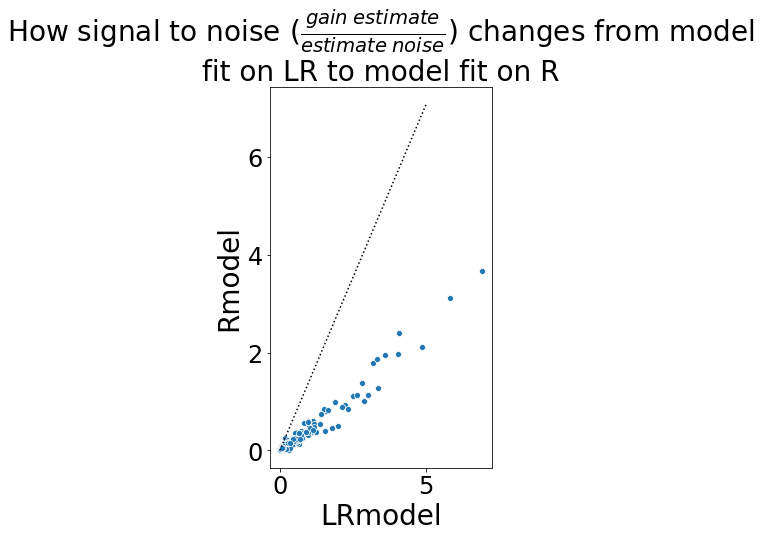

In [4]:
oldfits = np.load(f'./fits/ZM_2240/2020-01-22_session_2020-04-20_probe0_fit.p', allow_pickle=True)
oldfits = oldfits['fits']
olddf = oldfits[np.isfinite(oldfits.prior)]
newsnr = np.abs(fitdf.prior / fitdf.varprior)
oldsnr = np.abs(olddf.prior / olddf.varprior)
compdf = pd.concat([oldsnr, newsnr], axis=1, sort=True)
compdf.rename(columns={0: 'LRmodel', 1: 'Rmodel'}, inplace=True)
compdf = compdf.astype(float)
compdf[(compdf.LRmodel > 1e-3) & (compdf.Rmodel > 1e-3)]
sigdf = compdf[(compdf.LRmodel > 1e-3) & (compdf.Rmodel > 1e-3)]
logdf = np.log(sigdf)
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='LRmodel', y='Rmodel', data=sigdf)
ax.plot([0, 5], np.sqrt(2) * np.array([0, 5]), ':k')
plt.title(r'How signal to noise ($\frac{gain \; estimate}{estimate \; noise}$) changes from model' + '\n' +
          'fit on LR to model fit on R')
plt.tight_layout()

In [51]:
from glob import glob
fitnames = [fn for directory in os.listdir('./fits/') for fn in glob(f'./fits/{directory}/*session_2020-05*.p')]
fits = []
for fn in fitnames:
    currfits = np.load(fn, allow_pickle=True)
    if len(currfits['fits'][np.isfinite(currfits['fits'].prior)]) > 0:
        fits.append(currfits)
fitids = [(f['session_uuid'], f['probe_idx']) for f in fits]

In [52]:
from ibl_pipeline import ephys, subject
sessions = subject.Subject * subject.SubjectProject *\
    ephys.acquisition.Session * ephys.ProbeTrajectory()
bwm_sess = sessions & 'subject_project = "ibl_neuropixel_brainwide_01"' & \
    'task_protocol = "_iblrig_tasks_ephysChoiceWorld6.2.5"'
bwm = pd.DataFrame(bwm_sess.fetch())
bwm['session_uuid'] = bwm['session_uuid'].apply(str)
bwm.set_index(['session_uuid', 'probe_idx', 'insertion_data_source'], inplace=True)



In [53]:
idx = pd.IndexSlice
hist = bwm.loc[idx[:, :, ['Histology track']], idx[:]]
micro = bwm.loc[idx[:, :, ['Micro-manipulator']], idx[:]]
planned = bwm.loc[idx[:, :, ['Planned']], idx[:]]

coords = [] 
sources = [] 
for uuid, probe in fitids: 
    if hist.index.contains((uuid, probe, 'Histology track')): 
        coords.append(hist.loc[idx[uuid, probe, :]][['x', 'y', 'depth']].values.flatten()) 
        sources.append('Histology') 
    elif micro.index.contains((uuid, probe, 'Micro-manipulator')): 
        coords.append(micro.loc[idx[uuid, probe, :]][['x', 'y', 'depth']].values.flatten()) 
        sources.append('Micro-manipulator') 
    else: 
        coords.append(planned.loc[idx[uuid, probe, :]][['x', 'y', 'depth']].values.flatten()) 
        sources.append('Planning') 

/home/berk/anaconda3/envs/priorloc/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

The 'contains' method is deprecated and will be removed in a future version. Use 'key in index' instead of 'index.contains(key)'

/home/berk/anaconda3/envs/priorloc/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning:

The 'contains' method is deprecated and will be removed in a future version. Use 'key in index' instead of 'index.contains(key)'



In [63]:
fitdfs = [f['fits'][np.isfinite(f['fits'].prior)] for f in fits]
threshold = 1.
snr = [df.prior / (df.varprior + 1e-5)  for df in fitdfs]
props = [sum(df > 1) / len(df) for df in snr]
fitinfo = pd.DataFrame(columns=['x','y','z','source','prop', 'numcells'])
fitinfo['x'], fitinfo['y'], fitinfo['z'] = np.array(coords).T
fitinfo['source'] = sources
fitinfo['prop'] = props
fitinfo['numcells'] = [len(df) for df in snr]

/home/berk/anaconda3/envs/priorloc/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



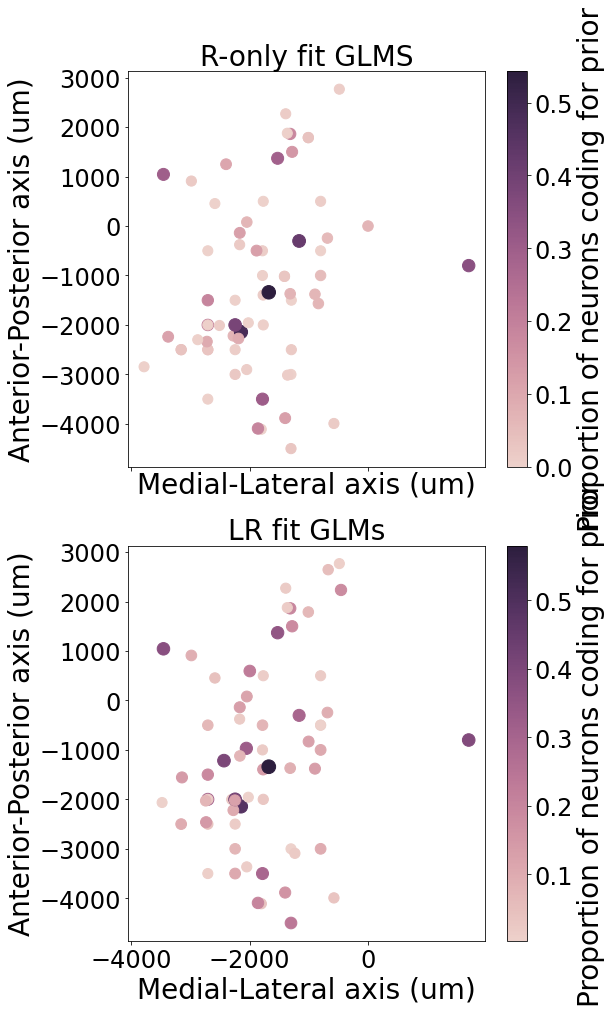

<Figure size 800x800 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [120]:
fig, axes = plt.subplots(2, 1, figsize=(8, 16), sharex=True, sharey=True)
sizemap = np.linspace(0, 0.7, 100) * 150 + 100
colors = sns.cubehelix_palette(as_cmap=True)
shalw = fitinfo[(fitinfo['z'] < 5000) & (fitinfo['numcells'] > 200)]
# cbins = np.linspace(shalw['prop'].min(), shalw['prop'].max(), 100)
# propcols = colors[np.digitize(shalw.prop, cbins) - 1]
sc = axes[0].scatter(shalw.x, shalw.y, c=shalw.prop, s=sizemap[np.digitize(shalw.prop, np.linspace(0, 0.7, 100))], cmap=colors)
axes[0].set_xlabel('Medial-Lateral axis (um)')
axes[0].set_ylabel('Anterior-Posterior axis (um)')
axes[0].set_title('R-only fit GLMS')
cb = fig.colorbar(sc, ax=axes[0])
cb.set_label('Proportion of neurons coding for prior')

oldstuff = np.load('/home/berk/Documents/wholebraintmp.p', allow_pickle=True)
olddf = oldstuff['newdf']
oldstuff.keys()
oldstuff['figure'].clear()
plt.figure(figsize=(8, 8))
sizemap = np.linspace(0, 0.7, 100) * 150 + 100
colors = sns.cubehelix_palette(as_cmap=True)
shalw = olddf[(olddf['z'] < 5000) & (fitinfo['numcells'] > 200)]
# cbins = np.linspace(shalw['prop'].min(), shalw['prop'].max(), 100)
# propcols = colors[np.digitize(shalw.prop, cbins) - 1]
sc = axes[1].scatter(shalw.x, shalw.y, c=shalw.prop, s=sizemap[np.digitize(shalw.prop, np.linspace(0, 0.7, 100))], cmap=colors)
axes[1].set_xlabel('Medial-Lateral axis (um)')
axes[1].set_ylabel('Anterior-Posterior axis (um)')
axes[1].set_title('LR fit GLMs')
cb = fig.colorbar(sc, ax=axes[1])
cb.set_label('Proportion of neurons coding for prior')

In [133]:
fitdf.iloc[0].decision_L.shape

(15,)

In [134]:
0.3/0.02

15.0

In [11]:
trdf.columns


Index(['choice', 'response_times', 'probabilityLeft', 'feedbackType',
       'feedback_times', 'contrastLeft', 'contrastRight', 'goCue_times',
       'stimOn_times', 'bias'],
      dtype='object')